# Měření velikosti zahřívané součátky
Tento úkol je zaměřen na využití kombinace dat z obyčejné RGB kamery a termokamery. Jako zahřívaná součástka bylo využito zařízení **Raspberry Pi 2 (Model B)** společně s **parazitními 2A rezistory** připojeny v USB.

Úkol má za cíl oživit dovednosti studentů při práci s obrazem, jakými jsou například projektivní transformace, segmentace nejen v barevných kanálech nebo měření velikostí v reálných jednotkách.

<img src="images/vv.png" width="50%"/>

### Import knihoven a konfigurace

In [3]:
%run ../svz.ipynb

from scipy.spatial import distance

### Pomocné funkce
Seznamte se, lze využít. Ostatní již známé funkce jsou v notebooku [svz](../../tutorials/svz.ipynb).

In [1]:
def select_image_points(img, points_cnt = 4):
    """ Opens a new image window, where user can interactively add or remove image points.
    Points are added while holding CTRL key + pressing left mouse button and removed by ALT key + pressing left mouse button.
    The point selection is terminated by pressing the 'q' key.
    
    Parameters
    ----------
    img : ndarray
        Input image where image points are choosen and drawn.
    points_cnt : Optional[int]
        A maximum number of points to choose. A minimum number of points to compute the projective transformation is 4.
    Returns
    -------
    list
        Returns a list of size >= 4 and size <= points_cnt such that each elements represent (x, y) coordinate in input image.
    """
    if points_cnt < 4: 
        raise ValueError('Number of points must be >= 4.')
        
    points = []
    window_name = 'Point selection'
    img_dimensions = img.shape[:2]
    pts_dist_thresh = 0.01 * img_dimensions[1] # Scale drawing elements with image size
    
    def draw_circle(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            if flags == cv2.EVENT_FLAG_ALTKEY + cv2.EVENT_LBUTTONDOWN: 
                for p in points:
                    if distance.euclidean(p, (x, y)) < pts_dist_thresh:
                        points.remove(p)
                        break
            elif flags == cv2.EVENT_FLAG_CTRLKEY + cv2.EVENT_LBUTTONDOWN and len(points) < points_cnt:
                points.append((x, y))           

    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL | cv2.WINDOW_GUI_NORMAL)
    cv2.resizeWindow(window_name, 1080, 720)
    cv2.moveWindow(window_name, 0, 0)
    cv2.setMouseCallback(window_name, draw_circle)
    
    # Drawing section, scale drawing elements with image size
    circle_diam = int(0.003 * img_dimensions[1])
    lbl_offset = int(0.005 * img_dimensions[1])
    lbl_font_scale = (0.001 * img_dimensions[1])
    lbl_thickness = int(0.003 * img_dimensions[1])
    
    while 1:
        drawn_img = img.copy()
        
        for i, p in enumerate(points):
            cv2.circle(drawn_img, p, circle_diam , (0, 0, 255), cv2.FILLED)
            cv2.putText(drawn_img, str(i), (p[0] + circle_diam + lbl_offset, p[1] + circle_diam + lbl_offset),
                        0, lbl_font_scale, (0, 0, 255), lbl_thickness)
            
        cv2.imshow(window_name, drawn_img)
        k = cv2.waitKey(1) & 0xFF
        
        if k == ord('q'):
            break

    cv2.destroyAllWindows()
    
    if len(points) < 3: 
        raise ValueError('Number of choosen points must be >= 4.')
        
    return points

def copy_to(src, dst, mask):
    '''Python alternative to C++/Java OpenCV's Mat.copyTo().
    More: https://docs.opencv.org/trunk/d3/d63/classcv_1_1Mat.html#a626fe5f96d02525e2604d2ad46dd574f'''
    locs = np.where(mask != 0) # Get the non-zero mask locations
    dst[locs[0], locs[1]] = src[locs[0], locs[1]]
    return dst

def show_scale(min_val, max_val, color_map='jet'):
    fig = plt.figure(figsize=(8, 3))
    ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
    norm = matplotlib.colors.Normalize(vmin=min_val, vmax=max_val)
    cb1 = matplotlib.colorbar.ColorbarBase(ax1, cmap=color_map, norm=norm, orientation='horizontal')
    cb1.set_label('Temperature °C')
    plt.show()

In [2]:
def normalized_image(img):
    # Dejte si pozor, že cv2.normalize nalezne minimální/maximální hodnotu v obraze vůči kterým normalizuje a tento vstup nelze změnit.
    # Můžeme pouze nastavit nové minimum a maximum. Později v úkolu budete muset napsat svoji "chytřejší" normalizaci.
    scaled = np.zeros_like(img)
    cv2.normalize(img, scaled, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    return scaled.astype('uint8')

def to_3_channels(image_one_channel):
    h,w = image_one_channel.shape
    image3 = np.zeros((h,w,3), dtype=np.uint8)
    image3[:,:,0] = image_one_channel
    image3[:,:,1] = image_one_channel
    image3[:,:,2] = image_one_channel
    return image3

def load_termo_csv(file_path):
    return np.genfromtxt(file_path, delimiter=';')[:, :-1]

---

## Úkol
K obrazové práci nad zahřívanou součástky jsou k dispozici nasnímaná data z rgb kamery a data reálných teplot z termokamery. Oboje je dostupné ve složce `data/`.

Za úkol je možné získat až **8 bodů** a až **2 prémiové**.

### 1) Načtěte data
Načtěte obrazová data ve formátu `png` a data teplot ve formátu `csv`. Data teplot obsahují reálné hodnoty teplot v jednotkách **°C** s přesností na desetinu stupně. Vhodně zobrazte jak data **obrazová**, tak data **teplot** obrázkem.

<div style="color: blue; text-align: right">[ 0,5 bodu ]</div>

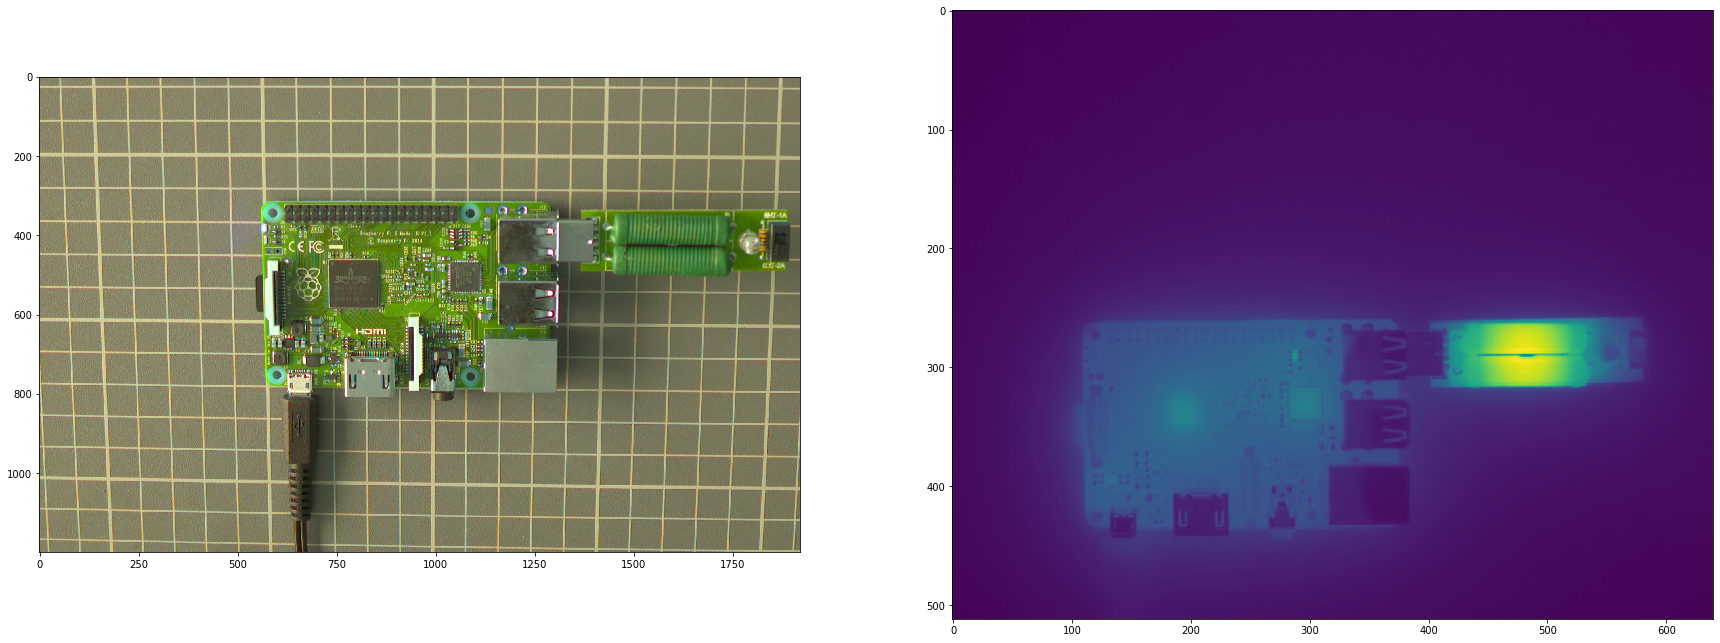

In [5]:
img = load_image('./data/data_rgb.png')
csv = load_termo_csv('./data/data_temps.csv')
plot_images(img, csv)

### 2) Vypište hodnoty několika teplot
Zvolte v obraze **3 body** a vypište hodnoty teploty v těchto bodech. Snažte se najít místa s **nejvyššími** teplotami.

<div style="color: blue; text-align: right">[ 0,5 bodu ]</div>

In [5]:
# points = select_image_points(normalized_image(csv))
points = [(481, 285), (482, 304), (194, 338)]

In [6]:
for point in points:
    print(csv[point])
points

31.3
31.0
30.8


[(481, 285), (482, 304), (194, 338)]

### 3) Namapujte termosnímek na RGB
Uvědomte si, že snímky **nejsou stejně velké** ani foceny ze **stejného úhlu**. Pamatujte, že je **důležité** uvědomit si **správně rovinu**, ve které pracujeme. Zobrazte jak obrázek RGB, tak namapovaný termosnímek.

Klíčová slova:
- přiřazení dvojic bodů
- hledání transformační matice
- warpování termosnímku na perspektivu RGB

<div style="color: blue; text-align: right">[ 1,5 bodu ]</div>

In [6]:
resized_img = cv2.resize(img, csv.shape[::-1])
resized_img_points = [(187, 137), (190, 332), (429, 337), (430, 138)]
csv_points = [(111, 264), (112, 434), (378, 435), (374, 260)]

In [8]:
H, _ = cv2.findHomography(np.array(csv_points),np.array(resized_img_points))
H

array([[0.984, 0.045, 74.985],
       [0.028, 1.260, -192.046],
       [0.000, 0.000, 1.000]])

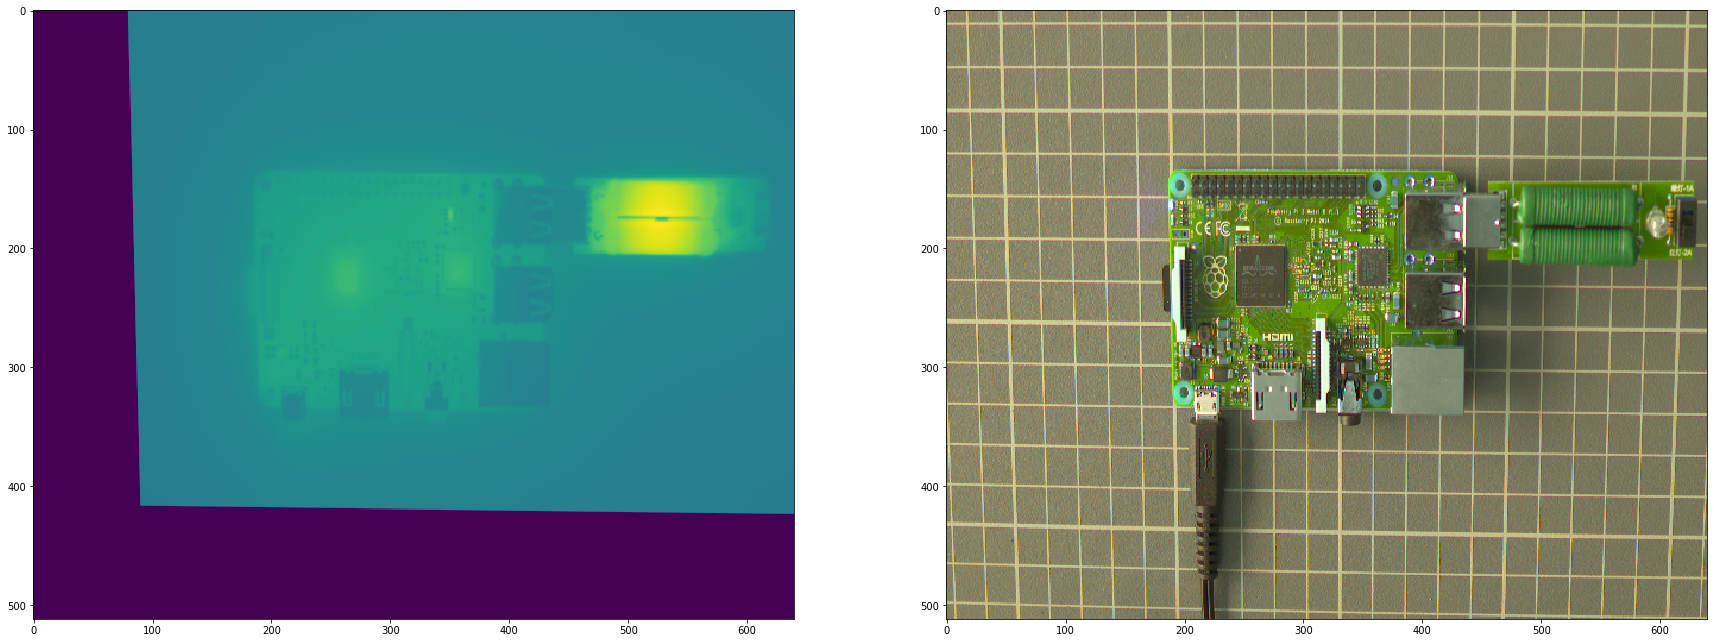

In [9]:
warped_csv = cv2.warpPerspective(csv, H, csv.shape[::-1])
plot_images(warped_csv, resized_img)


### 4) Segmentujte v termosnímku
Pomocí rozsahu **reálných teplot** (ne jasových hodnot) vytvořte binární masku, která bude obsahovat **celé Raspberry Pi** bez připojených USB rezistorů. Masku zobrazte.

<div style="color: blue; text-align: right">[ 1,5 bodu ]</div>

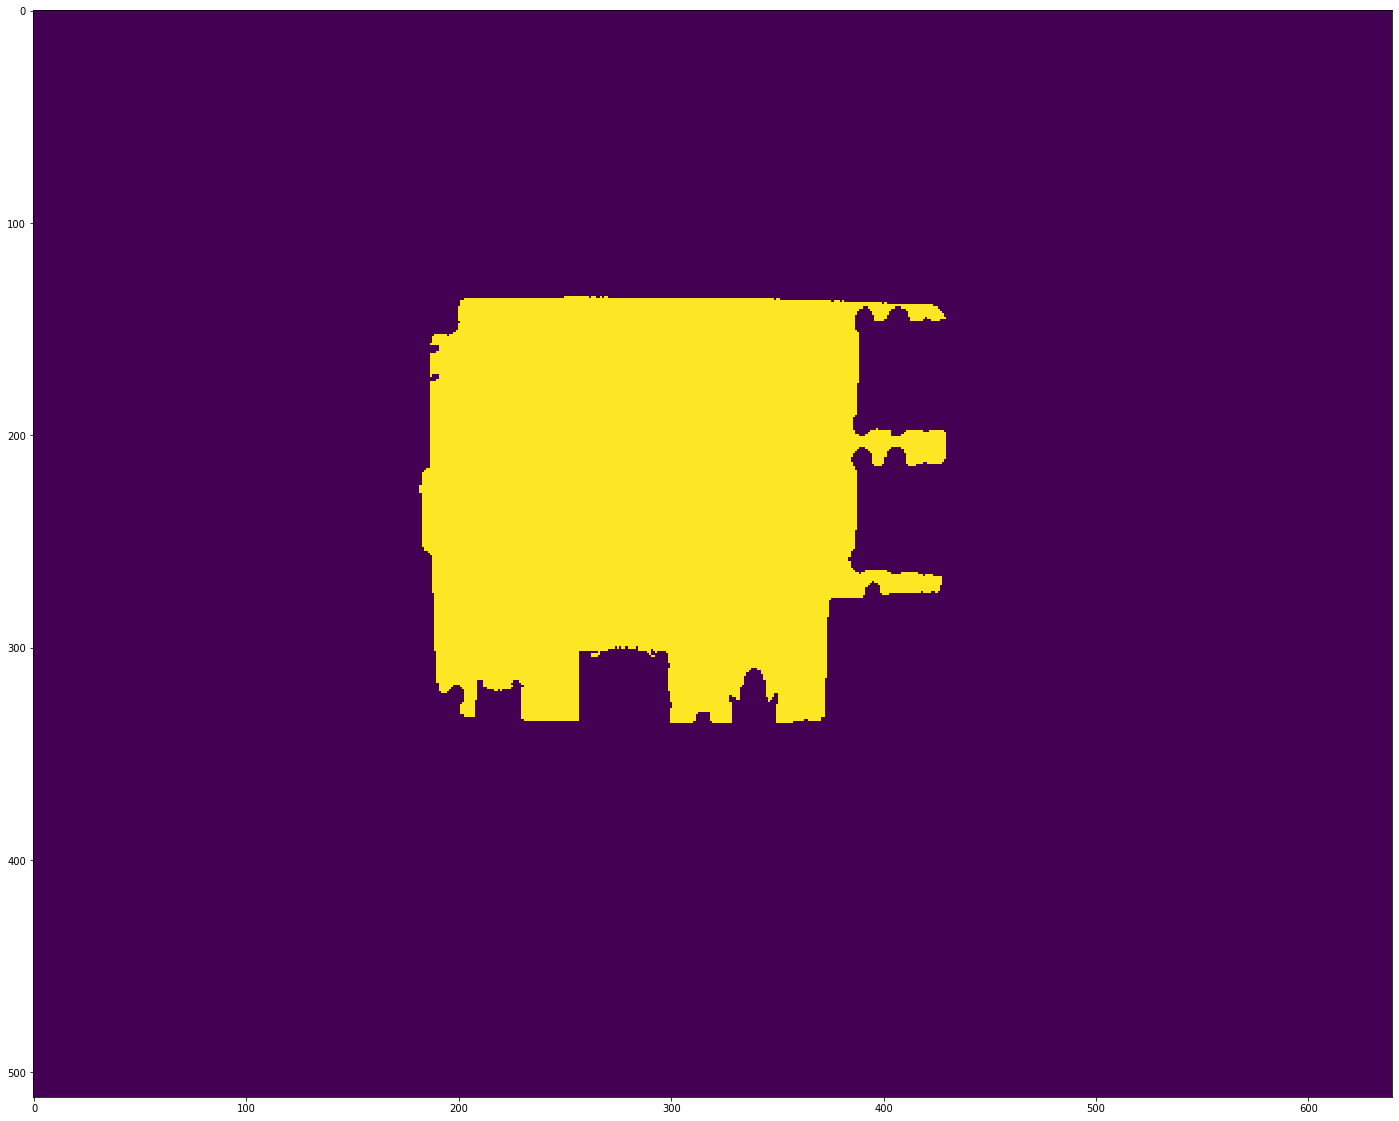

In [10]:
bin_mask = segmentation_two_thresholds(warped_csv, 37, 50)
contours_bin, _ , cnt =find_contours(bin_mask, min_area=15000)
plot_images(contours_bin)

### 5) Aplikujte data teplot na RGB obraz
Pomocí výše vytvořené **binární masky** segmentujte **data teplot**. Ty následně zobrazte pomocí vybrané [JET colormapy](https://docs.opencv.org/3.2.0/d3/d50/group__imgproc__colormap.html). Jako dílčí výstup **vytvořte funkci** pro **min-max normalizaci** teplotních hodnot obrazu, která přímá na vstupu **min, max, newmin, newmax**. Bude se hodit při aplikaci colormapy. Dále se vám může hodit funkce `to_3_channels()` k snadnějším bitovým operacím. Její využití však není podmínkou, způsobů získání výsledku je více.

Snímek by měl vypadat následovně (nenechte se zmást zobrazením BGR $\leftrightarrow$ RGB při používání matplotlibu).

<img src="images/fuse.png" width="50%"/>

Klíčová slova:
- min-max normalizace
- aplikace colormapy
- segmentace pomocí masky
- vážené spojení dvou obrazů

<div style="color: blue; text-align: right">[ 1,5 bodu ]</div>

In [11]:
# Min-max normalization
def min_max_norm(image):
    image *= 230.0/image.max()
    return image 

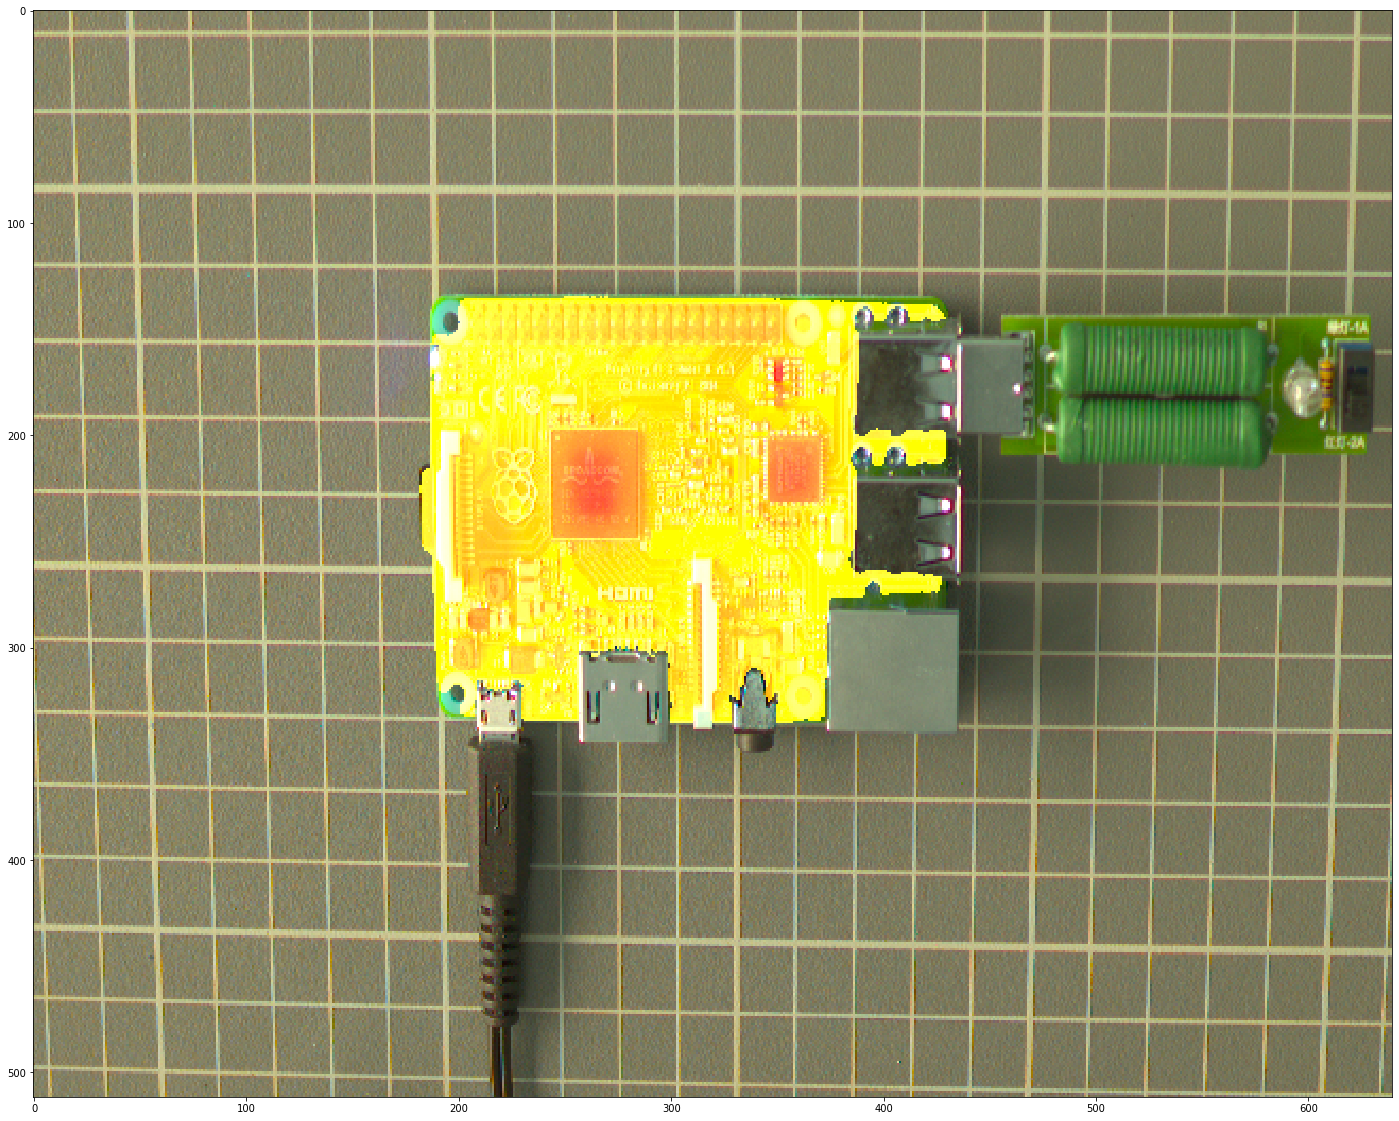

In [12]:
tmp = mask(warped_csv, contours_bin)
tmp = min_max_norm(tmp)
tmp = cv2.applyColorMap(tmp.astype(np.uint8), cv2.COLORMAP_JET)
masked_colorjet = mask(tmp[:,:,::-1], contours_bin)
plot_images(cv2.addWeighted(masked_colorjet, 1, resized_img, 1, 0))

### 6) Segmentujte součástky
Využijte teplotní data k segmentaci **pouze 2 zahřívajících se** součástek - mikročipů. Zajímá nás plocha, která má teplotu vyšší než **43 °C**.

Při jejich hledání **využijte** informaci, že hledané mikročipy mají přibližně tvar čtverce.

<div style="color: blue; text-align: right">[ 1,5 bodu ]</div>

2

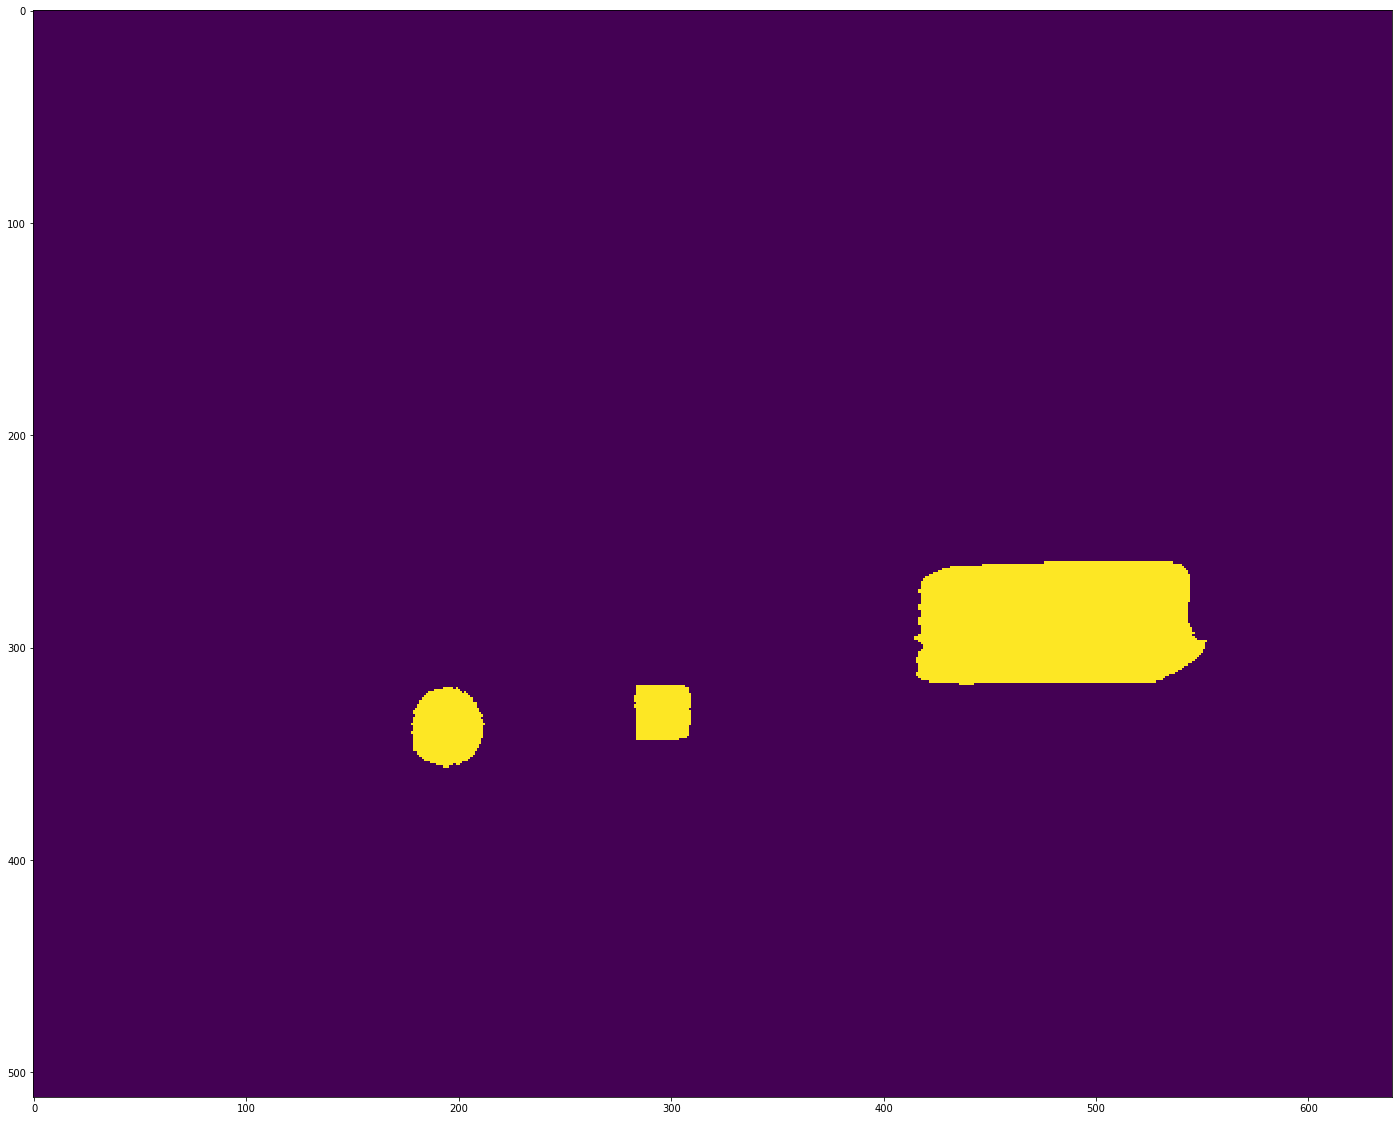

In [13]:
bin_mask = segmentation_one_threshold(csv, 43).astype(np.uint8)
cnt_bin, _, cnts = find_contours(bin_mask, min_area=200)
plot_images(cnt_bin)
chips = []
for cnt in cnts:
    dims = cv2.minAreaRect(cnt)[1]
    min_diameter = min(dims)
    max_diameter = max(dims)
    ar = ShapeDescriptors.aspect_ratio(min_diameter, max_diameter)
    if ar > .85:
        chips.append(cnt)
len(chips)

### 7) Zjistěte velikost mikročipů v reálných jednotkách
Zjistěte pro každý mikročip, jak velká je celková zahřívaná plocha v cm$^2$, mající vyšší teplotu než je pro nás kritických **43 °C**. Pro přechod z pixelů do reálných jednotek jsme důkladně cvičili 2 různé způsoby. V tomto případě, je ale jeden z nich správnější, než ten druhý. Vyberte, který chcete, o absolutní přesnost zde v tuhle chvíli nejde. Disktutujte však správnost vybraného postupu.

**HINT -** Perspektiva.

<div style="color: blue; text-align: right">[ 1 bod ]</div>

In [14]:
rasp_mount_holes_dimm = 5.8, 4.9

In [15]:
# show_images(resized_img)
a = 362 - 195  # didnt have to use pythagoras, since the y coordinate was the same
b = 322 - 200

In [16]:
sq_ratio = rasp_mount_holes_dimm[0]*rasp_mount_holes_dimm[1]/(a*b)

In [17]:
for chip in chips:
    print(f'{cv2.contourArea(chip)*sq_ratio:.3f}cm{chr(0x00B2)}')

1.329cm²
0.854cm²


---

### 8) Prémium #1
Nabízím 1 prémiový bod za detekci středů kružnic v RGB i v termo automatizovaně pomocí algoritmů. Například pomocí Houghovy transformace nebo i třeba hranové detekce + tvarových charakteristik. Jde primárně o díry na šrouby, které lze využít k hledání korespondenčních bodů a následné aplikaci perspektivní transformace.

### 9) Prémium #2
Nabízím 1 prémiový bod za výpočet plochy v cm$^2$ obou mikročipů v RGB obraze. Následně je nutné výsledky dát do poměru s vypočtenou plochou z termo snímku, která se zahřívala nad kritických 43° C. Tím lze například porovnat, který z nich se více zahřívá.

In [ ]:
show_images(resized_img)
chips_coords = [[(245, 198), (284, 247)], [(347, 201), (370, 231)]] 
chip_size_px = [(x[1][0] - x[0][0])*(x[1][1] - x[0][1]) for x in chips_coords]  # Zde se skryva prachobyc a*b
for whole, hot in zip(chip_size_px, chips):
    print(f'{cv2.contourArea(hot)*sq_ratio:.3f}cm{chr(0x00B2)} se zahřívalo z celkových {whole*sq_ratio:.3f}cm{chr(0x00B2)} tudíž je to {cv2.contourArea(hot)/whole*100:.3f}%')

x = 244, y = 197
x = 283, y = 247
